**PREPARACION INICIAL DE LOS DATOS Y COMPROBACIÓN DE CARGA CORRECTA**


In [ ]:
import pandas as pd

# 1. Cargar datasets
ruta_uber = "/content/df_procesado_uber.csv"
ruta_spy = "/content/df_spy_lstm.csv"

df_spy = pd.read_csv(ruta_spy, index_col=0, parse_dates=True)
df_uber = pd.read_csv(ruta_uber, index_col=0, parse_dates=True)

# 2. Limpiar nombres de columnas (eliminar espacios extra)
df_spy.columns = df_spy.columns.str.strip()
df_uber.columns = df_uber.columns.str.strip()

# 3. Convertir el índice en columna (si es necesario)
if "open" not in df_uber.columns:
    df_uber["open"] = df_uber.index  # Pasar índice a columna
    df_uber.reset_index(drop=True, inplace=True)  # Resetear índice


# 4. Eliminar variables que podrían sesgar el modelo
df_spy = df_spy.drop(columns=["volatility"], errors="ignore")
df_spy = df_spy.drop(columns=["open_UBER"], errors="ignore")
df_uber = df_uber.drop(columns=["open_SPY"], errors="ignore")

# 5. Filtrar columnas para que coincidan con SPY (quitando las extra de UBER)
columnas_comunes = [col for col in df_spy.columns if col in df_uber.columns]
df_uber = df_uber[columnas_comunes]  # Mantener solo las columnas que coinciden


# 5. Filtrar columnas para que coincidan con SPY (quitando las extra de UBER)
columnas_comunes = [col for col in df_uber.columns if col in df_spy.columns]
df_spy = df_spy[columnas_comunes]  # Mantener solo las columnas que coinciden

# 6. Comprobar que todo está bien alineado
print("Columnas finales SPY:", df_spy.columns.tolist())
print("Columnas finales UBER:", df_uber.columns.tolist())



x = len(df_spy.columns)
y = len(df_uber.columns)
print(x, y)

Columnas finales SPY: ['open', 'volume', 'News Sentiment', 'open_APPL', 'open_AMZN', 'open_AVGO', 'open_BRK.B', 'open_GOOGL', 'open_GOOG', 'open_META', 'open_MSFT', 'open_NVDA', 'RSI', 'ema_long', 'MACD', 'MACD_signal', 'bollinger_mid', 'bollinger_std', 'ATR', 'monthly_return']
Columnas finales UBER: ['open', 'volume', 'News Sentiment', 'open_APPL', 'open_AMZN', 'open_AVGO', 'open_BRK.B', 'open_GOOGL', 'open_GOOG', 'open_META', 'open_MSFT', 'open_NVDA', 'RSI', 'ema_long', 'MACD', 'MACD_signal', 'bollinger_mid', 'bollinger_std', 'ATR', 'monthly_return']
20 20


**DEFINICION INICIAL DE FUNCIONES Y CUESTIONES INICIALES**


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Función para normalizar datos
def normalizar_datos(df):
    scaler = MinMaxScaler()
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_norm, scaler

# Función para crear secuencias de datos
def crear_secuencias(datos, n_pasos):
    X, y = [], []
    for i in range(n_pasos, len(datos)):
        X.append(datos.iloc[i - n_pasos:i].values)
        y.append(datos.iloc[i]["open"])
    return np.array(X), np.array(y)

# Función para construir modelo LSTM con Masking para ignorar los ceros
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking

def construir_gru(n_pasos, n_features):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(n_pasos, n_features)),  # Ignorar valores 0
        GRU(50, return_sequences=True),  # Primera capa GRU
        Dropout(0.2),
        GRU(50, return_sequences=False),  # Segunda capa GRU
        Dropout(0.2),
        Dense(25, activation="relu"),  # Capa densa intermedia
        Dense(1)  # Capa de salida para predicción
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# Función para construir modelo LSTM con Masking para ignorar los ceros
def construir_lstm(n_pasos, n_features):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(n_pasos, n_features)),  # Ignorar valores 0
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


  # Crear el DataFrame vacío para almacenar las métricas
metricas = pd.DataFrame(columns=[
    'RMSE Sin TL',
    'RMSE Con TL',
    'RMSE Adj. Sin TL',
    'RMSE Adj. Con TL',
    'MAE Sin TL',
    'MAE Con TL',
    'R2 Sin TL',
    'R2 Con TL',
    'MAPE Sin TL',
    'MAPE Con TL',
    'Porcentaje Train Tesla',
    'Modelo (GRU / LSTM)','Años de datos',
    'Épocas modelo base',
    'Épocas fine-tuning',
    'Capas congeladas',
])

**PREDICCION BOOTSTRAP INTERVALS DEFINITION**

# **MODELO CON REGLAS ESTABLECIDAS DE HIPERPARÁMETROS**

Años de datos disponibles para Uber: 4.64
Usando modelo GRU (años de datos: 4.64 ≤ 5)
Épocas para modelo base: 47
Épocas para fine-tuning: 32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - loss: 0.0193
Epoch 2/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - loss: 0.0023
Epoch 3/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - loss: 0.0014
Epoch 4/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - loss: 0.0012
Epoch 5/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - loss: 9.9008e-04
Epoch 6/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - loss: 8.7585e-04
Epoch 7/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 8.9196e-04
Epoch 8/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - loss: 9.1401e-04
Epoch 9/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 7.0799e-04
Epoch 10/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - loss: 6.1047e-04
Epoch 11/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - loss: 7.2669e-04
Epoch 12/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 6.0946e-04
Epoch 13/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - loss: 5.6996e-04
Epoch 14/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - loss: 

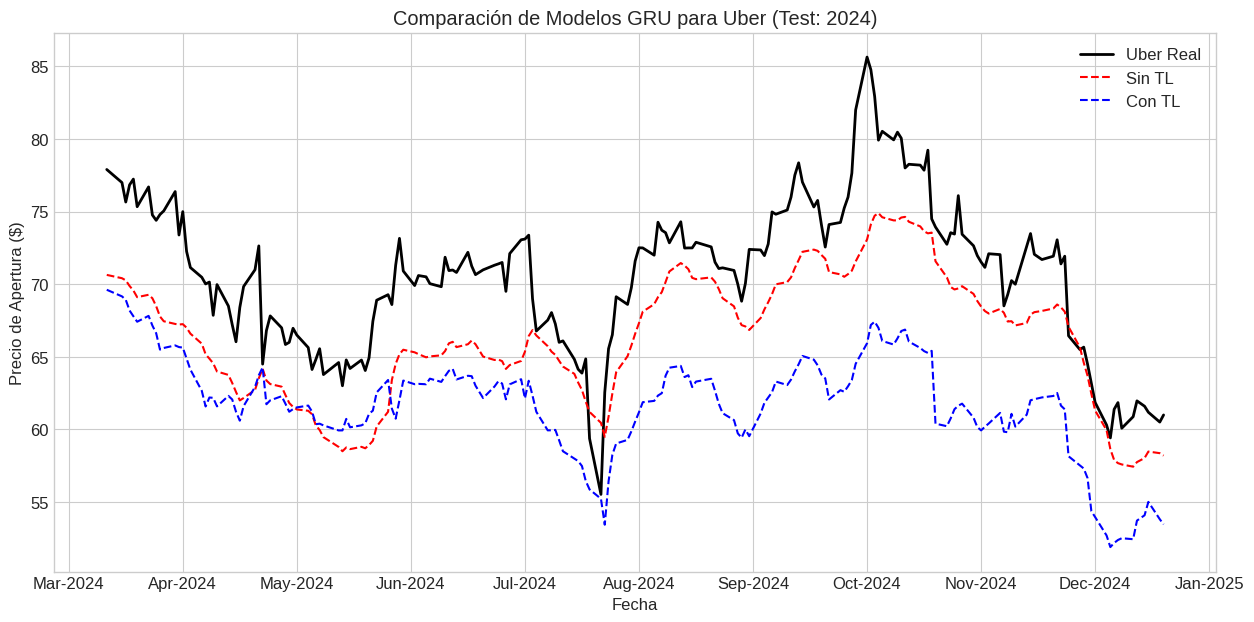


Comparación de métricas:
RMSE Sin TL: 4.94, Con TL: 9.46
RMSE Adj. Sin TL: 0.0699, Con TL: 0.1338
MAE Sin TL: 4.43, Con TL: 8.97
R2 Sin TL: 0.0972, Con TL: -2.3021
MAPE Sin TL: 6.19%, Con TL: 12.52%


<ipython-input-4-644bc3f7b0a4>:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metricas = pd.concat([metricas, pd.DataFrame({


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from dateutil.relativedelta import relativedelta

# 1. CONFIGURACIÓN DE PARÁMETROS
año_entrenamiento = 2023
n_pasos = 60

# 2. DIVISIÓN DEL CONJUNTO DE DATOS
df_spy_train = df_spy[:f'2019-05-10']
df_uber_train = df_uber['2019-05-10':f'{año_entrenamiento}-12-31']

año_prueba = año_entrenamiento + 1
df_uber_test = df_uber[f'{año_prueba}-01-01':f'{año_prueba}-12-31']

# Cálculo dinámico de años de datos disponibles para Uber
inicio_uber = pd.to_datetime('2019-05-10')
fin_entrenamiento = pd.to_datetime(f'{año_entrenamiento}-12-31')
años_de_datos = (fin_entrenamiento - inicio_uber).days / 365.25

print(f"Años de datos disponibles para Uber: {años_de_datos:.2f}")

# Selección dinámica del tipo de modelo
if años_de_datos <= 5:
    print(f"Usando modelo GRU (años de datos: {años_de_datos:.2f} ≤ 5)")
    construir_modelo = construir_gru
    tipo_modelo = "GRU"
else:
    print(f"Usando modelo LSTM (años de datos: {años_de_datos:.2f} > 5)")
    construir_modelo = construir_lstm
    tipo_modelo = "LSTM"

# Cálculo dinámico de épocas
epocas_modelo_base = max(10, int(50 - (años_de_datos / 2)))
epocas_fine_tuning = min(100, int(30 + (años_de_datos / 2)))

print(f"Épocas para modelo base: {epocas_modelo_base}")
print(f"Épocas para fine-tuning: {epocas_fine_tuning}")

# 3. NORMALIZACIÓN DE DATOS
scaler_spy = MinMaxScaler()
df_spy_train_norm = pd.DataFrame(scaler_spy.fit_transform(df_spy_train), columns=df_spy.columns, index=df_spy_train.index)

scaler_uber = MinMaxScaler()
df_uber_train_norm = pd.DataFrame(scaler_uber.fit_transform(df_uber_train), columns=df_uber.columns, index=df_uber_train.index)

df_uber_test_norm = pd.DataFrame(scaler_uber.transform(df_uber_test), columns=df_uber.columns, index=df_uber_test.index)

# 4. CREACIÓN DE SECUENCIAS DE DATOS PARA ENTRENAMIENTO
X_spy, y_spy = crear_secuencias(df_spy_train_norm, n_pasos)
X_uber, y_uber = crear_secuencias(df_uber_train_norm, n_pasos)

# 5. CONSTRUCCIÓN Y ENTRENAMIENTO DE MODELOS

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Modelo base SPY
modelo_spy = construir_modelo(n_pasos, X_spy.shape[2])
modelo_spy.fit(X_spy, y_spy, epochs=epocas_modelo_base, batch_size=16, verbose=1, callbacks=[early_stopping])

# Modelo Uber sin transfer learning
modelo_uber = construir_modelo(n_pasos, X_uber.shape[2])
modelo_uber.fit(X_uber, y_uber, epochs=50, batch_size=16, verbose=1, callbacks=[early_stopping])

# 6. TRANSFER LEARNING: AFINAR MODELO SPY CON UBER
modelo_spy_tuned = tf.keras.models.clone_model(modelo_spy)
modelo_spy_tuned.set_weights(modelo_spy.get_weights())

# Cálculo dinámico de capas a congelar
total_capas_entrenables = len([layer for layer in modelo_spy_tuned.layers if len(layer.weights) > 0])
capas_a_congelar = max(0, int(total_capas_entrenables - (años_de_datos / 2)))

print(f"Total de capas entrenables: {total_capas_entrenables}")
print(f"Capas a congelar: {capas_a_congelar}")

# Congelar capas según la fórmula
capas_congeladas = 0
for layer in modelo_spy_tuned.layers:
    if len(layer.weights) > 0:  # Solo considerar capas con pesos
        if capas_congeladas < capas_a_congelar:
            layer.trainable = False
            capas_congeladas += 1
            print(f"Capa {layer.name} congelada")
        else:
            layer.trainable = True
            print(f"Capa {layer.name} entrenable")

modelo_spy_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse")
modelo_spy_tuned.fit(X_uber, y_uber, epochs=epocas_fine_tuning, batch_size=16, verbose=1, callbacks=[early_stopping])

# 7. PREDICCIONES EN DATOS DE TEST
X_test, y_test = crear_secuencias(df_uber_test_norm, n_pasos)

pred_sin_tl = modelo_uber.predict(X_test)
pred_con_tl = modelo_spy_tuned.predict(X_test)

# 8. DESNORMALIZACIÓN DE PREDICCIONES
y_test_real = scaler_uber.inverse_transform(
    np.hstack([y_test.reshape(-1, 1)] + [np.zeros((y_test.shape[0], df_uber.shape[1] - 1))])
)[:, df_uber.columns.get_loc("open")]

pred_sin_tl_real = scaler_uber.inverse_transform(
    np.hstack([pred_sin_tl] + [np.zeros((pred_sin_tl.shape[0], df_uber.shape[1] - 1))])
)[:, df_uber.columns.get_loc("open")]

pred_con_tl_real = scaler_uber.inverse_transform(
    np.hstack([pred_con_tl] + [np.zeros((pred_con_tl.shape[0], df_uber.shape[1] - 1))])
)[:, df_uber.columns.get_loc("open")]

# 9. CÁLCULO DE MÉTRICAS DE ERROR
rmse_sin_tl = np.sqrt(mean_squared_error(y_test_real, pred_sin_tl_real))
rmse_con_tl = np.sqrt(mean_squared_error(y_test_real, pred_con_tl_real))

rmse_adj_sin_tl = rmse_sin_tl / np.average(y_test_real)
rmse_adj_con_tl = rmse_con_tl / np.average(y_test_real)

mae_sin_tl = mean_absolute_error(y_test_real, pred_sin_tl_real)
mae_con_tl = mean_absolute_error(y_test_real, pred_con_tl_real)

r2_sin_tl = r2_score(y_test_real, pred_sin_tl_real)
r2_con_tl = r2_score(y_test_real, pred_con_tl_real)

mape_sin_tl = np.mean(np.abs((y_test_real - pred_sin_tl_real) / y_test_real)) * 100
mape_con_tl = np.mean(np.abs((y_test_real - pred_con_tl_real) / y_test_real)) * 100

# 10. GRÁFICO DE COMPARACIÓN DE MODELOS
plt.figure(figsize=(15, 7))
plt.plot(df_uber_test.iloc[n_pasos:].index, y_test_real, label="Uber Real", color="black", linewidth=2)
plt.plot(df_uber_test.iloc[n_pasos:].index, pred_sin_tl_real, label="Sin TL", color="red", linestyle="dashed")
plt.plot(df_uber_test.iloc[n_pasos:].index, pred_con_tl_real, label="Con TL", color="blue", linestyle="dashed")
plt.title(f"Comparación de Modelos {tipo_modelo} para Uber (Test: {año_entrenamiento+1})")
plt.xlabel("Fecha")
plt.ylabel("Precio de Apertura ($)")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%b-%Y"))
plt.legend()
plt.grid(True)
plt.show()

# 11. ALMACENAR MÉTRICAS EN UN DATAFRAME
porcentaje_train_uber = len(df_uber_train) / len(df_uber) * 100

metricas = pd.concat([metricas, pd.DataFrame({
    'RMSE Sin TL': [rmse_sin_tl],
    'RMSE Con TL': [rmse_con_tl],
    'RMSE Adj. Sin TL': [rmse_adj_sin_tl],
    'RMSE Adj. Con TL': [rmse_adj_con_tl],
    'MAE Sin TL': [mae_sin_tl],
    'MAE Con TL': [mae_con_tl],
    'R2 Sin TL': [r2_sin_tl],
    'R2 Con TL': [r2_con_tl],
    'MAPE Sin TL': [mape_sin_tl],
    'MAPE Con TL': [mape_con_tl],
    'Porcentaje Train Uber': [porcentaje_train_uber],
    'Modelo (GRU / LSTM)': [tipo_modelo],
    'Años de datos': [años_de_datos],
    'Épocas modelo base': [epocas_modelo_base],
    'Épocas fine-tuning': [epocas_fine_tuning],
    'Capas congeladas': [capas_a_congelar]
}, index=[f'Año {año_entrenamiento}+{1}'])], ignore_index=False)

# Mostrar las métricas
print("\nComparación de métricas:")
print(f"RMSE Sin TL: {rmse_sin_tl:.2f}, Con TL: {rmse_con_tl:.2f}")
print(f"RMSE Adj. Sin TL: {rmse_adj_sin_tl:.4f}, Con TL: {rmse_adj_con_tl:.4f}")
print(f"MAE Sin TL: {mae_sin_tl:.2f}, Con TL: {mae_con_tl:.2f}")
print(f"R2 Sin TL: {r2_sin_tl:.4f}, Con TL: {r2_con_tl:.4f}")
print(f"MAPE Sin TL: {mape_sin_tl:.2f}%, Con TL: {mape_con_tl:.2f}%")

# Análisis de Volatilidad


<ipython-input-7-2a57a360defa>:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df_uber.resample('Y').agg({'ATR': 'mean'})


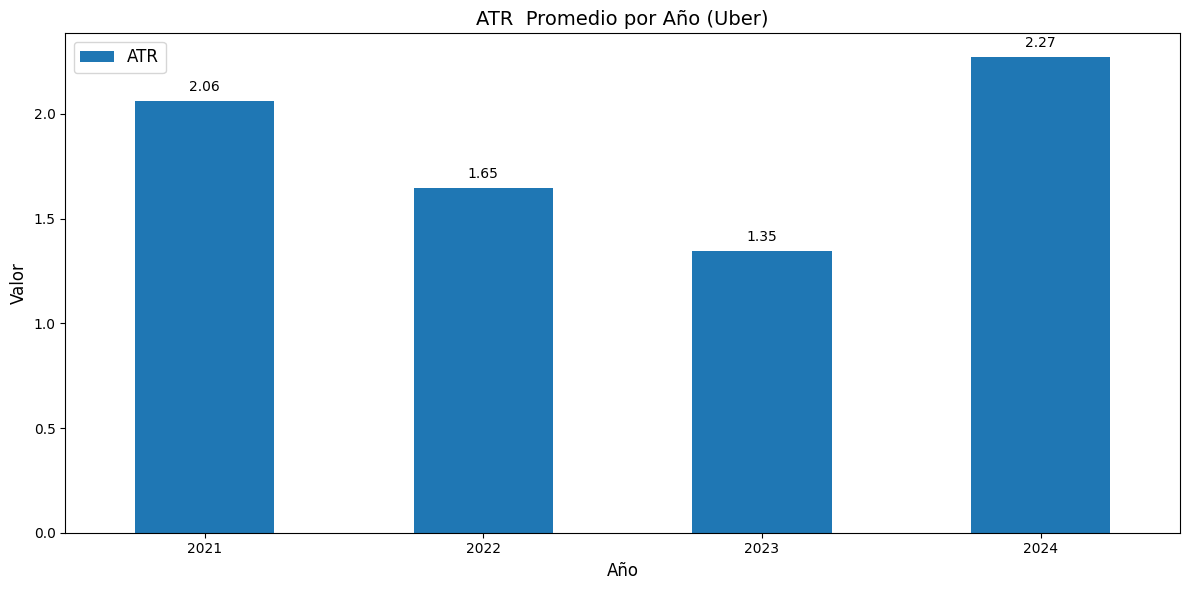

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Resampleo por año y calculo el ATR y la volatilidad promedio
df_yearly = df_uber.resample('Y').agg({'ATR': 'mean'})

# Filtrar para eliminar los años 2019 y 2020
df_yearly = df_yearly[~df_yearly.index.year.isin([2019, 2020])]

# Convertir el índice a solo el año
df_yearly.index = df_yearly.index.year

# Graficar ATR y volatilidad promedio por año
plt.figure(figsize=(12, 6))
ax = df_yearly[['ATR']].plot(kind='bar', ax=plt.gca())

# Mejoras en el gráfico
plt.title('ATR  Promedio por Año (Uber)', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=0)  # Asegurarse de que las etiquetas estén solo con el año
plt.legend(['ATR'], fontsize=12)

# Añadir las etiquetas en la parte superior de las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=10)

# Ajuste de la estética
plt.tight_layout()
plt.show()

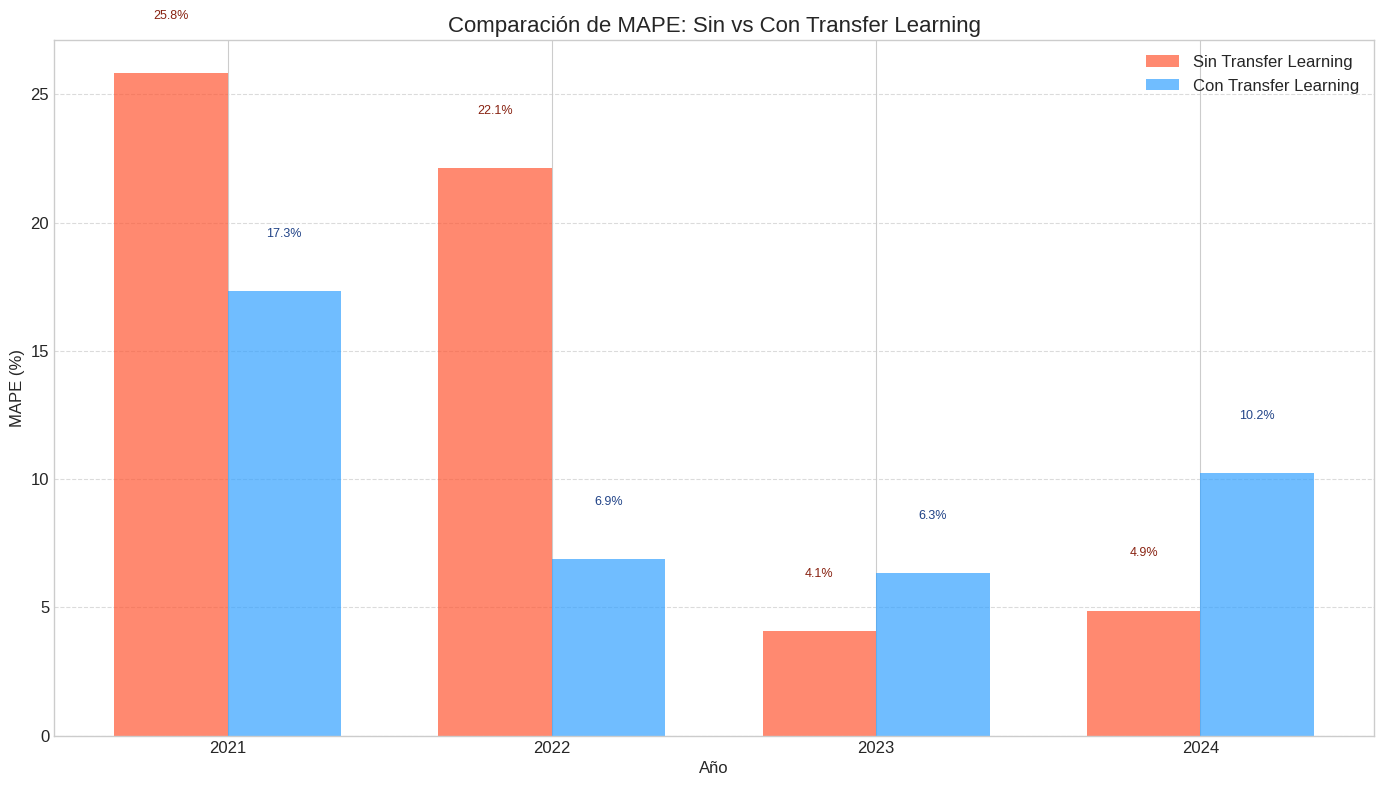

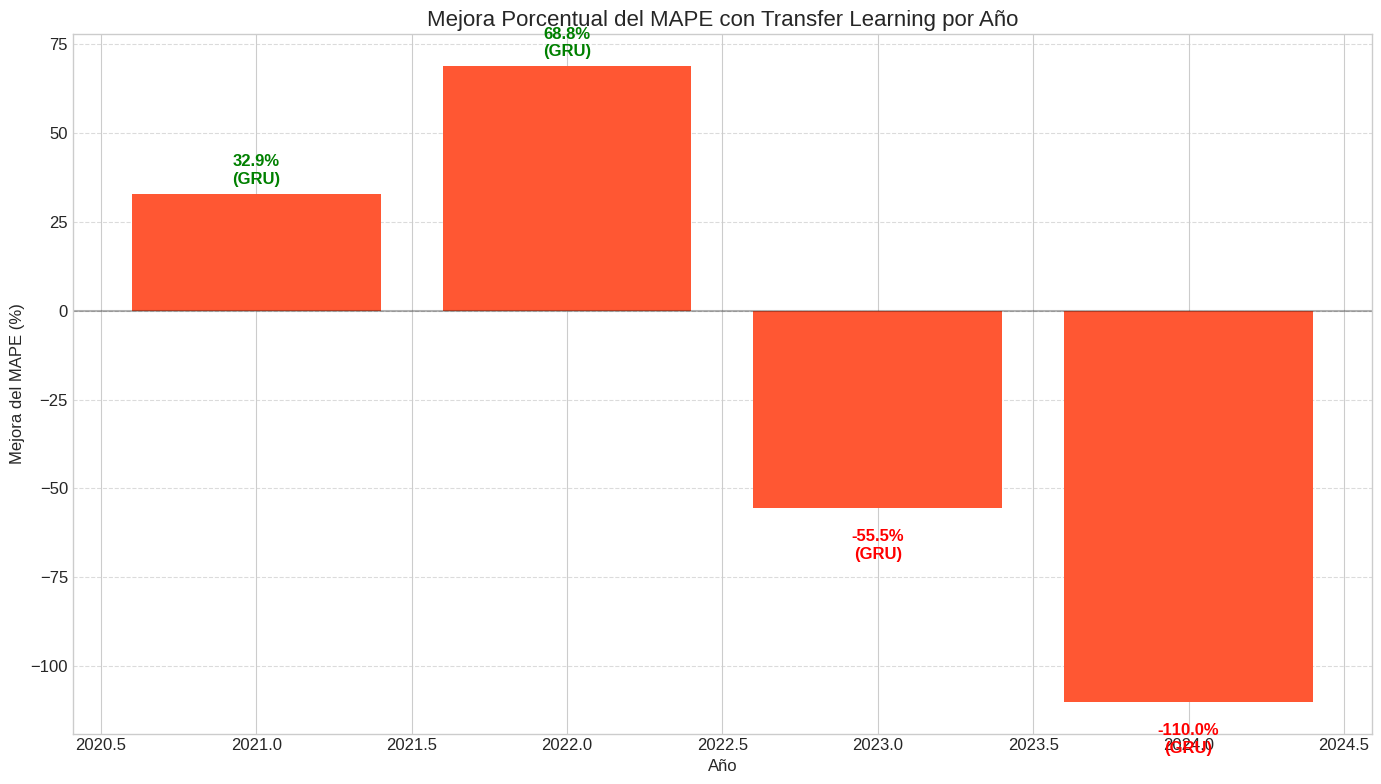

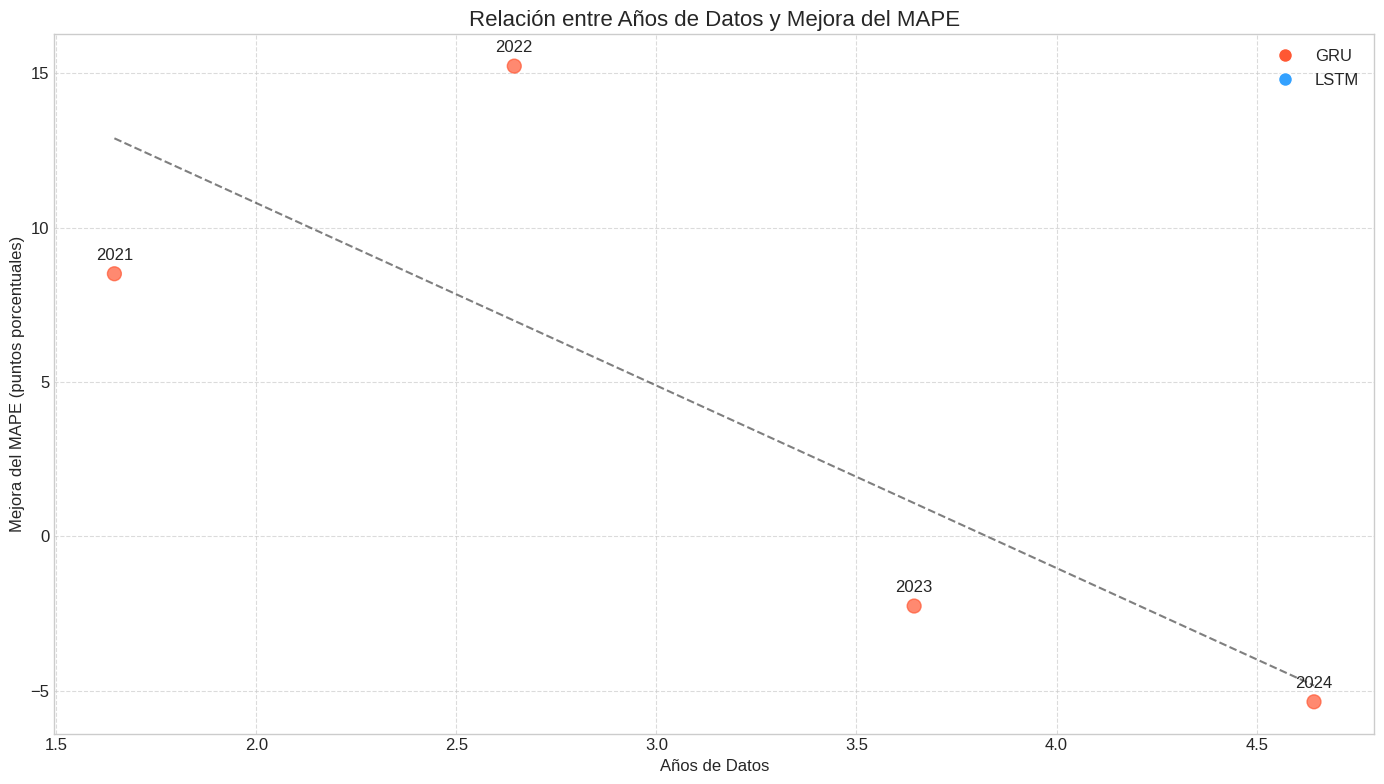

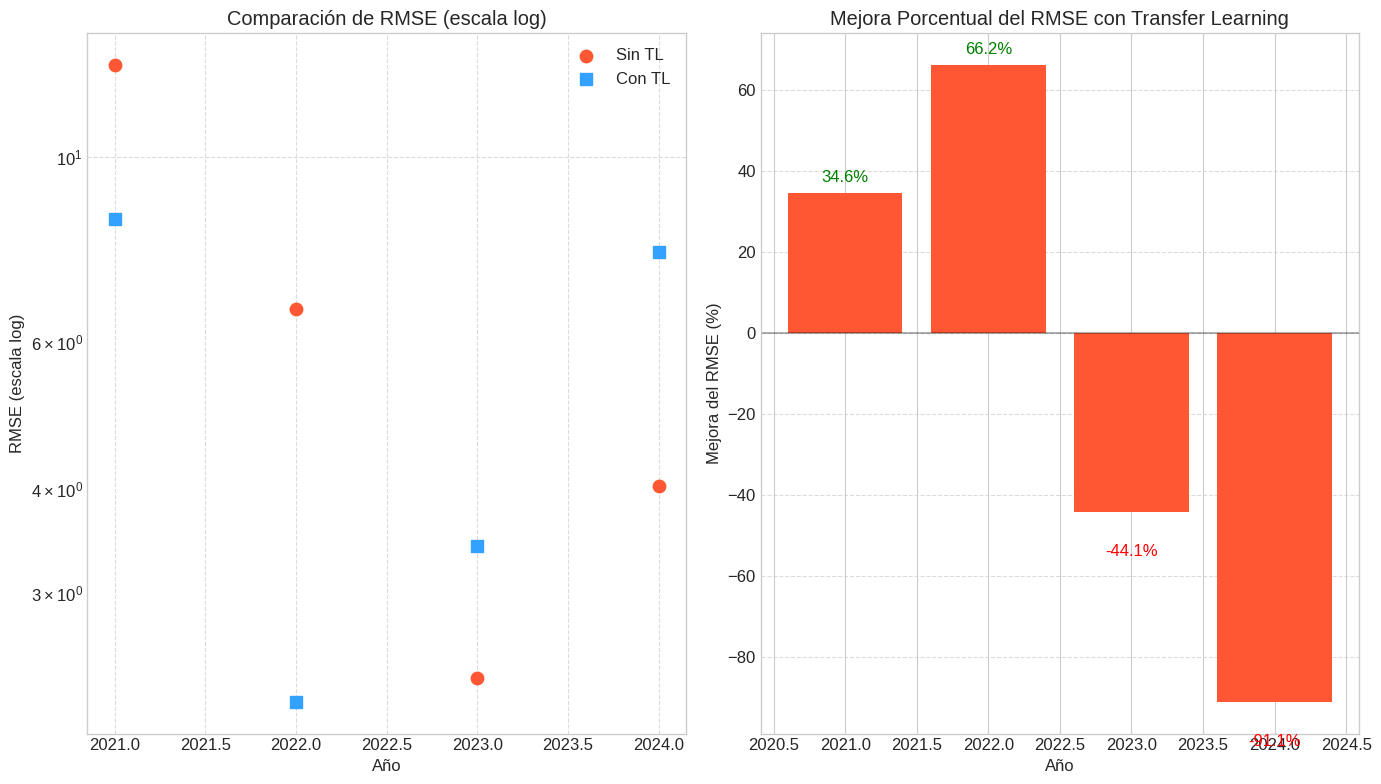

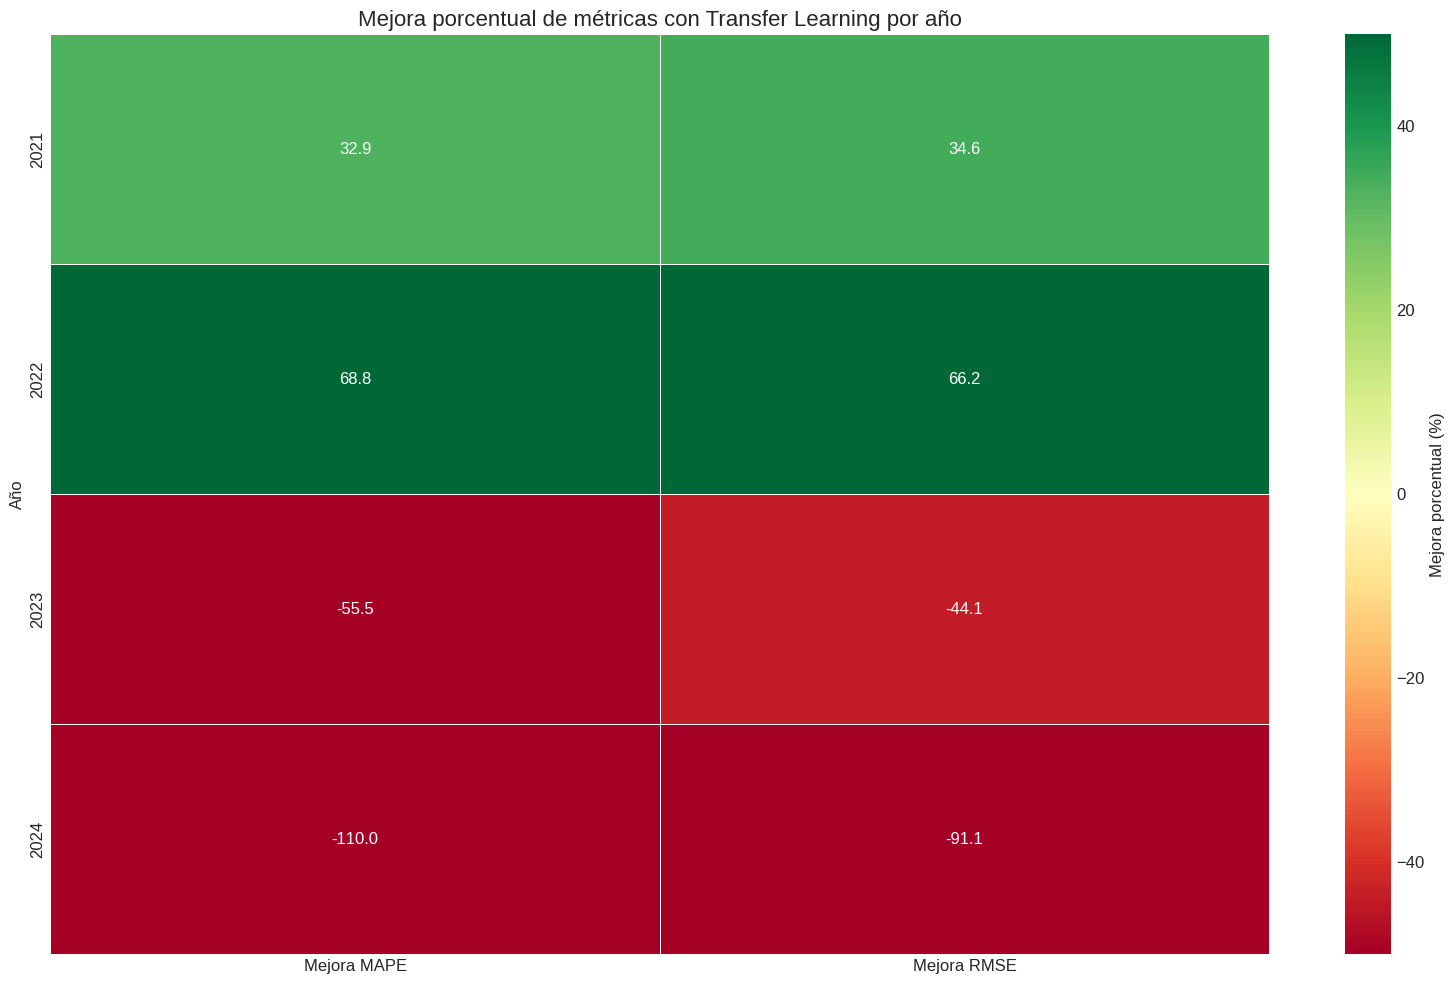

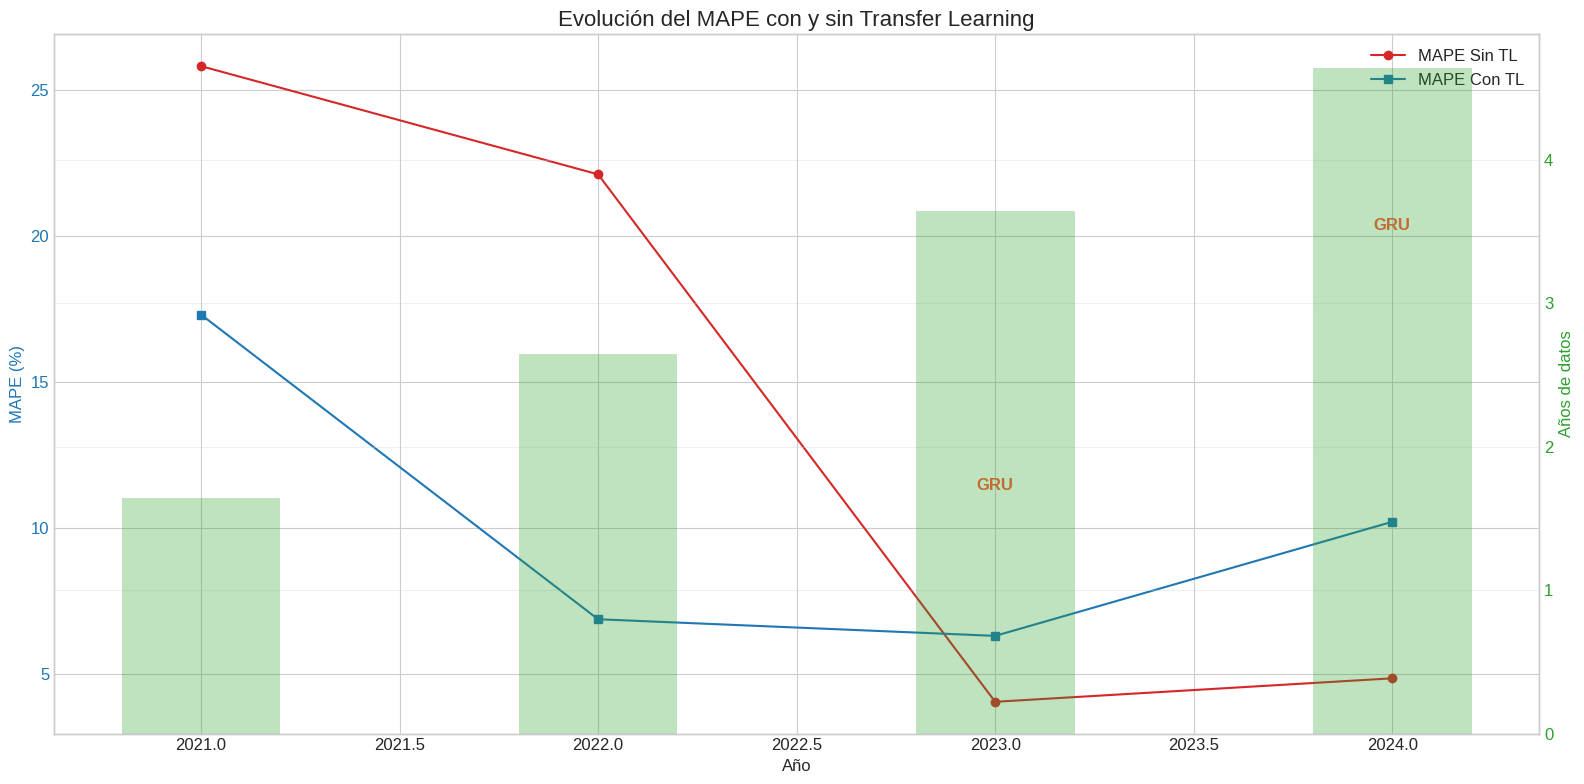

Resumen de mejoras con Transfer Learning:
Mejora media del MAPE: 4.03 puntos porcentuales
Mejora porcentual media del MAPE: -15.94%
Número de años con mejora en MAPE: 2 de 4
Mejora media del RMSE: 1.02
Mejora porcentual media del RMSE: -8.61%
Número de años con mejora en RMSE: 2 de 4

Comparación por tipo de modelo:
        Mejora MAPE %  Mejora RMSE %
Modelo                              
GRU        -15.944308      -8.613723


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el diccionario de datos
data = {
    'Año': [2021, 2022, 2023, 2024],
    'RMSE Sin TL': [12.893126, 6.568495, 2.372429, 4.027238],
    'RMSE Con TL': [8.435649, 2.221471, 3.419128, 7.695569],
    'RMSE Adj. Sin TL': [0.277584, 0.240618, 0.052982, 0.056957],
    'RMSE Adj. Con TL': [0.181616, 0.081377, 0.076357, 0.108839],
    'MAE Sin TL': [11.112561, 5.923569, 1.950498, 3.513193],
    'MAE Con TL': [7.516391, 1.806991, 2.950753, 7.334814],
    'R2 Sin TL': [-4.119358, -1.999043, 0.913372, 0.401186],
    'R2 Con TL': [-1.191473, 0.65697, 0.82007, -1.186547],
    'MAPE Sin TL': [25.823583, 22.119155, 4.06483, 4.868615],
    'MAPE Con TL': [17.319386, 6.89098, 6.321312, 10.22618],
    'Modelo': ['GRU', 'GRU', 'GRU', 'GRU'],
    'Años de datos': [1.645448, 2.644764, 3.644079, 4.643395],
    'Épocas modelo base': [49, 48, 48, 47],
    'Épocas fine-tuning': [30, 31, 31, 32],
    'Capas congeladas': [3, 2, 2, 1],
    'Porcentaje Train Uber': [29.275158, 47.009148, 64.672766, 82.26601]
}



# Crear el DataFrame
metricas = pd.DataFrame(data)

# Calcular la diferencia de MAPE (mejora)
metricas['Mejora MAPE'] = metricas['MAPE Sin TL'] - metricas['MAPE Con TL']
metricas['Mejora MAPE %'] = (metricas['Mejora MAPE'] / metricas['MAPE Sin TL']) * 100
metricas['Mejora RMSE'] = metricas['RMSE Sin TL'] - metricas['RMSE Con TL']
metricas['Mejora RMSE %'] = (metricas['Mejora RMSE'] / metricas['RMSE Sin TL']) * 100

# Configuración estética para los gráficos
plt.style.use('seaborn-v0_8-whitegrid')
colors = {'GRU': '#FF5733', 'LSTM': '#33A1FF'}
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# 1. Gráfico de comparación de MAPE (Sin TL vs Con TL)
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(metricas['Año']))

plt.bar(index, metricas['MAPE Sin TL'], bar_width, label='Sin Transfer Learning', color='#FF5733', alpha=0.7)
plt.bar(index + bar_width, metricas['MAPE Con TL'], bar_width, label='Con Transfer Learning', color='#33A1FF', alpha=0.7)

plt.xlabel('Año')
plt.ylabel('MAPE (%)')
plt.title('Comparación de MAPE: Sin vs Con Transfer Learning', fontsize=16)
plt.xticks(index + bar_width/2, metricas['Año'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v1, v2 in zip(index, metricas['MAPE Sin TL'], metricas['MAPE Con TL']):
    if v1 > v2:
        plt.text(i, v1+2, f"{v1:.1f}%", ha='center', va='bottom', fontsize=9, color='#882211')
        plt.text(i + bar_width, v2+2, f"{v2:.1f}%", ha='center', va='bottom', fontsize=9, color='#224488')
    else:
        plt.text(i, v1+2, f"{v1:.1f}%", ha='center', va='bottom', fontsize=9, color='#882211')
        plt.text(i + bar_width, v2+2, f"{v2:.1f}%", ha='center', va='bottom', fontsize=9, color='#224488')

plt.tight_layout()
plt.show()

# 2. Gráfico de mejora porcentual del MAPE por año
plt.figure(figsize=(14, 8))
bars = plt.bar(metricas['Año'], metricas['Mejora MAPE %'], color=[colors[modelo] for modelo in metricas['Modelo']])

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Año')
plt.ylabel('Mejora del MAPE (%)')
plt.title('Mejora Porcentual del MAPE con Transfer Learning por Año', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir valores y colores según el tipo de modelo
for bar, year, value, modelo in zip(bars, metricas['Año'], metricas['Mejora MAPE %'], metricas['Modelo']):
    color = 'green' if value > 0 else 'red'
    plt.text(bar.get_x() + bar.get_width()/2,
             value + (2 if value > 0 else -6),
             f"{value:.1f}%\n({modelo})",
             ha='center', va='bottom' if value > 0 else 'top',
             color=color, fontweight='bold')

plt.tight_layout()
plt.show()

# 3. Gráfico de dispersión: Mejora MAPE vs Años de datos
plt.figure(figsize=(14, 8))
scatter = plt.scatter(metricas['Años de datos'],
                      metricas['Mejora MAPE'],
                      c=[colors[m] for m in metricas['Modelo']],
                      s=100,
                      alpha=0.7)

plt.xlabel('Años de Datos')
plt.ylabel('Mejora del MAPE (puntos porcentuales)')
plt.title('Relación entre Años de Datos y Mejora del MAPE', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Añadir línea de tendencia
z = np.polyfit(metricas['Años de datos'], metricas['Mejora MAPE'], 1)
p = np.poly1d(z)
plt.plot(metricas['Años de datos'], p(metricas['Años de datos']), "k--", alpha=0.5)

# Añadir etiquetas de año
for x, y, año in zip(metricas['Años de datos'], metricas['Mejora MAPE'], metricas['Año']):
    plt.annotate(str(año), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Crear leyenda para los modelos
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['GRU'], markersize=10, label='GRU'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['LSTM'], markersize=10, label='LSTM')]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# 4. Gráfico de RMSE comparativo
plt.figure(figsize=(14, 8))

# Usar escala logarítmica para RMSE debido a la gran variación
plt.subplot(1, 2, 1)
plt.scatter(metricas['Año'], metricas['RMSE Sin TL'], label='Sin TL', color='#FF5733', s=80, marker='o')
plt.scatter(metricas['Año'], metricas['RMSE Con TL'], label='Con TL', color='#33A1FF', s=80, marker='s')
plt.yscale('log')
plt.xlabel('Año')
plt.ylabel('RMSE (escala log)')
plt.title('Comparación de RMSE (escala log)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Mejora porcentual de RMSE
plt.subplot(1, 2, 2)
bars = plt.bar(metricas['Año'], metricas['Mejora RMSE %'], color=[colors[modelo] for modelo in metricas['Modelo']])
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Año')
plt.ylabel('Mejora del RMSE (%)')
plt.title('Mejora Porcentual del RMSE con Transfer Learning')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, value in zip(bars, metricas['Mejora RMSE %']):
    color = 'green' if value > 0 else 'red'
    plt.text(bar.get_x() + bar.get_width()/2,
             value + (2 if value > 0 else -8),
             f"{value:.1f}%",
             ha='center', va='bottom' if value > 0 else 'top',
             color=color)

plt.tight_layout()
plt.show()

# 5. Heatmap de la mejora por año y tipo de métrica
plt.figure(figsize=(16, 10))

# Preparar datos para el heatmap
heatmap_data = metricas[['Año', 'Mejora MAPE %', 'Mejora RMSE %']]
heatmap_data = heatmap_data.set_index('Año')
heatmap_data.columns = ['Mejora MAPE', 'Mejora RMSE']

# Crear un mapa de calor
ax = sns.heatmap(heatmap_data,
                cmap="RdYlGn",
                annot=True,
                fmt=".1f",
                linewidths=.5,
                center=0,
                vmin=-50,
                vmax=50,
                cbar_kws={'label': 'Mejora porcentual (%)'})

plt.title('Mejora porcentual de métricas con Transfer Learning por año', fontsize=16)
plt.tight_layout()
plt.show()

# 6. Gráfico de resumen de MAPE y modelo usado
fig, ax1 = plt.subplots(figsize=(16, 8))

# MAPE comparativo
ax1.set_xlabel('Año')
ax1.set_ylabel('MAPE (%)', color='tab:blue')
ax1.plot(metricas['Año'], metricas['MAPE Sin TL'], 'o-', color='tab:red', label='MAPE Sin TL')
ax1.plot(metricas['Año'], metricas['MAPE Con TL'], 's-', color='tab:blue', label='MAPE Con TL')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Añadir información del modelo usado
for i, (year, mape_sin, mape_con, modelo) in enumerate(zip(metricas['Año'],
                                                         metricas['MAPE Sin TL'],
                                                         metricas['MAPE Con TL'],
                                                         metricas['Modelo'])):
    # Posicionar las etiquetas alternando arriba y abajo para claridad
    y_pos = max(mape_sin, mape_con) + (5 if i % 2 == 0 else 10)
    ax1.annotate(f"{modelo}", (year, y_pos),
                 color=colors[modelo],
                 weight='bold',
                 ha='center')

# Añadir años de datos en un eje secundario
ax2 = ax1.twinx()
ax2.set_ylabel('Años de datos', color='tab:green')
ax2.bar(metricas['Año'], metricas['Años de datos'], alpha=0.3, color='tab:green', width=0.4)
ax2.tick_params(axis='y', labelcolor='tab:green')

# Añadir línea de separación GRU/LSTM
cambio_modelo_idx = metricas[metricas['Modelo'] == 'LSTM'].index.min()
if pd.notna(cambio_modelo_idx):
    año_cambio = metricas.loc[cambio_modelo_idx, 'Año']
    plt.axvline(x=año_cambio - 0.5, color='black', linestyle='--', alpha=0.5)
    plt.text(año_cambio - 0.5, plt.ylim()[1] * 0.9, 'Cambio a LSTM',
             rotation=90, va='top', ha='right', alpha=0.7)

ax1.legend(loc='upper right')
plt.title('Evolución del MAPE con y sin Transfer Learning', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Estadísticas de resumen
print("Resumen de mejoras con Transfer Learning:")
print(f"Mejora media del MAPE: {metricas['Mejora MAPE'].mean():.2f} puntos porcentuales")
print(f"Mejora porcentual media del MAPE: {metricas['Mejora MAPE %'].mean():.2f}%")
print(f"Número de años con mejora en MAPE: {(metricas['Mejora MAPE'] > 0).sum()} de {len(metricas)}")
print(f"Mejora media del RMSE: {metricas['Mejora RMSE'].mean():.2f}")
print(f"Mejora porcentual media del RMSE: {metricas['Mejora RMSE %'].mean():.2f}%")
print(f"Número de años con mejora en RMSE: {(metricas['Mejora RMSE'] > 0).sum()} de {len(metricas)}")

# Análisis por tipo de modelo
print("\nComparación por tipo de modelo:")
print(metricas.groupby('Modelo')[['Mejora MAPE %', 'Mejora RMSE %']].mean())

# **ANÁLISIS DE MÉTRICAS**

In [ ]:
metricas

,RMSE Sin TL,RMSE Con TL,RMSE Adj. Sin TL,RMSE Adj. Con TL,MAE Sin TL,MAE Con TL,R2 Sin TL,R2 Con TL,MAPE Sin TL,MAPE Con TL,Porcentaje Train Tesla,Mejora RMSE,Mejora RMSE Adj,Mejora MAE,Mejora MAPE
Año 2011+1,1.660616,1.062683,0.802468,0.513526,1.583507,0.950380,-110.455667,-44.642714,77.071317,47.280151,10.460022,36.006678,36.006678,39.982548,38.654026
Año 2015+1,2.500892,1.338057,0.175221,0.093749,2.283457,1.293545,-3.040660,-0.156676,16.263141,9.191287,38.006572,46.496800,46.496800,43.351491,43.483937
Año 2020+1,31.605249,41.623220,0.120475,0.158662,22.795513,31.223867,0.710747,0.498316,7.756125,11.110842,72.480832,-31.697173,-31.697173,-36.973743,-43.252498
Año 2023+1,38.811052,42.741147,0.160797,0.177080,31.754051,28.418278,0.747611,0.693908,12.447812,9.692730,93.099671,-10.126225,-10.126225,10.505030,22.133062


In [ ]:

# Apply round function
metricas = metricas.round(2)
